In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models.segmentation as models
from torch.utils.data import Dataset, DataLoader 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [24]:

# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_dataset = SegmentationDataset("Kvasir-SEG/images", "Kvasir-SEG/masks", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [25]:
model = model.cpu()

In [26]:
model = models.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Adjust output channels to 1 for binary segmentation

# Use CPU
device = torch.device("cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Loss: 0.27505678045749665, IoU: 0.4668409546613693, Dice: 0.6282711310386657, Accuracy: 0.8842564849853516
Epoch 2/10, Loss: 0.199779835999012, IoU: 0.5830847690105438, Dice: 0.7300212965011597, Accuracy: 0.913143051147461
Epoch 3/10, Loss: 0.166884685754776, IoU: 0.6409993553161621, Dice: 0.7768417916297913, Accuracy: 0.9246210479736328
Epoch 4/10, Loss: 0.1593928354382515, IoU: 0.6559781312942505, Dice: 0.7872046608924865, Accuracy: 0.9271944885253907
Epoch 5/10, Loss: 0.13581114518642426, IoU: 0.6972990458011628, Dice: 0.8176349601745605, Accuracy: 0.9357577362060547
Epoch 6/10, Loss: 0.13177062779664994, IoU: 0.7130519876480103, Dice: 0.8293652348518371, Accuracy: 0.9386991882324218
Epoch 7/10, Loss: 0.1138074947297573, IoU: 0.7445566051006317, Dice: 0.8504089088439941, Accuracy: 0.9448208618164062
Epoch 8/10, Loss: 0.10644651618599892, IoU: 0.759010537147522, Dice: 0.8603431115150452, Accuracy: 0.9472250671386718
Epoch 9/10, Loss: 0.09517315244674683, IoU: 0.7875420336

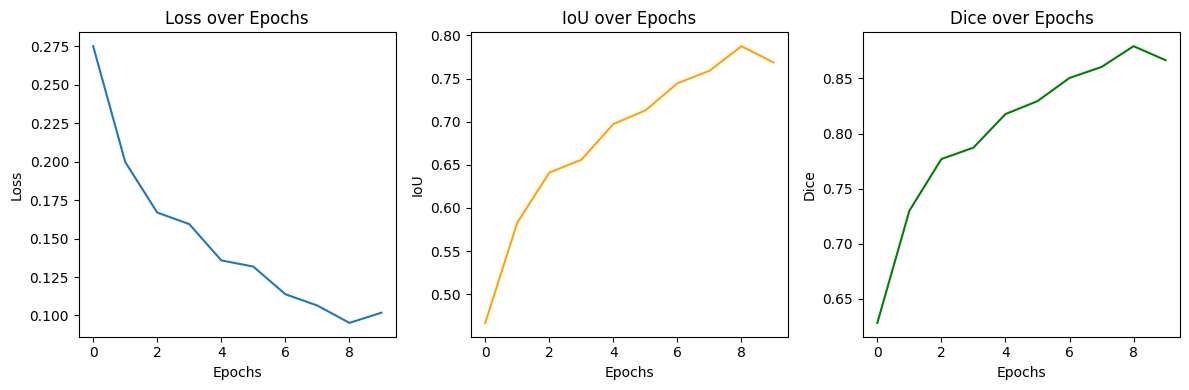

In [9]:
def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5  # Ensure target is also a binary mask
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return (intersection + smooth) / (union + smooth)

def dice_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5  # Ensure target is also a binary mask
    intersection = (pred & target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)


# Training Loop
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    best_iou = 0.0
    train_loss_history = []
    train_iou_history = []
    train_dice_history = []
    
    # Use CPU
    device = torch.device("cpu")
    model = model.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_iou = 0
        epoch_dice = 0
        correct = 0
        total = 0
        
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_iou += iou_score(outputs, masks).item()
            epoch_dice += dice_score(outputs, masks).item()
            
            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted == masks).sum().item()
            total += masks.numel()
        
        accuracy = correct / total
        epoch_loss /= len(dataloader)
        epoch_iou /= len(dataloader)
        epoch_dice /= len(dataloader)
        
        train_loss_history.append(epoch_loss)
        train_iou_history.append(epoch_iou)
        train_dice_history.append(epoch_dice)
        
        # Save the best model based on IoU score
        if epoch_iou > best_iou:
            best_iou = epoch_iou
            torch.save(model.state_dict(), "best_model.pth")
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, IoU: {epoch_iou}, Dice: {epoch_dice}, Accuracy: {accuracy}")
    
    print("Training complete.")
    
    # Plot the metrics
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history, label="Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.subplot(1, 3, 2)
    plt.plot(train_iou_history, label="IoU", color="orange")
    plt.title("IoU over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    
    plt.subplot(1, 3, 3)
    plt.plot(train_dice_history, label="Dice", color="green")
    plt.title("Dice over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Dice")
    
    plt.tight_layout()
    plt.show()

# Assuming your model, dataloader, criterion, and optimizer are already defined
train_model(model, train_loader, criterion, optimizer, num_epochs=10)